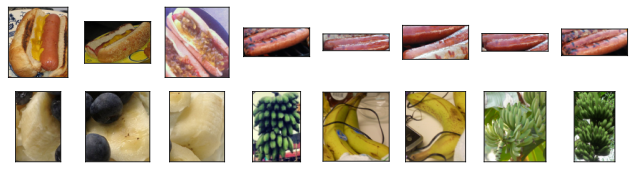

In [65]:
import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

def train_batch_ch13(net, X, y, loss, trainer, devices):
    """Train for a minibatch with multiple GPUs (defined in Chapter 13)."""
    if isinstance(X, list):
        # Required for BERT fine-tuning (to be covered later)
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

#@save
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=d2l.try_all_gpus()):
    """Train a model with multiple GPUs (defined in Chapter 13)."""
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples,
        # no. of predictions
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(
                net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

d2l.DATA_HUB['hotdog'] = (d2l.DATA_URL + 'hotdog.zip',
                         'fba480ffa8aa7e0febbb511d181409f899b9baa5')
data_dir = d2l.download_extract('hotdog')
train_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'))
test_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'))
hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [train_imgs[-i - 1][0] for i in range(8)]
d2l.show_images(hotdogs + not_hotdogs, 2, 8, scale=1.4)
normalize = torchvision.transforms.Normalize(
    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    normalize])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize([256, 256]),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    normalize])

loss 0.178, train acc 0.932, test acc 0.946
1857.3 examples/sec on [device(type='cuda', index=0)]


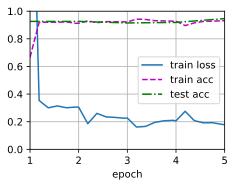

In [67]:
pretrained_net = torchvision.models.resnet18(pretrained=True)
finetune_net = pretrained_net
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
nn.init.xavier_uniform_(finetune_net.fc.weight)

# If `param_group=True`, the model parameters in the output layer will be
# updated using a learning rate ten times greater
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5,
                      param_group=True):
    train_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train'), transform=train_augs),
        batch_size=batch_size, shuffle=True)
    test_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'test'), transform=test_augs),
        batch_size=batch_size)
    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction="none")
    if param_group:
        params_1x = [param for name, param in net.named_parameters()
             if name not in ["fc.weight", "fc.bias"]]
        trainer = torch.optim.SGD([{'params': params_1x},
                                   {'params': net.fc.parameters(),
                                    'lr': learning_rate * 10}],
                                lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate,
                                  weight_decay=0.001)
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
                   devices)

train_fine_tuning(finetune_net, 5e-5)


561 728
torch.Size([1, 2042040, 4])


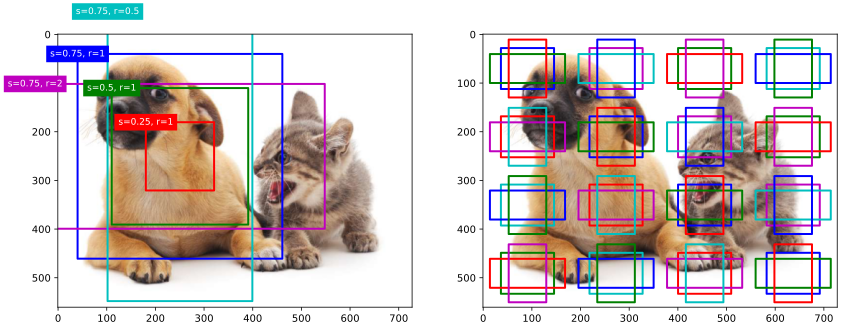

In [99]:
# note size(scale) here is (0, 1) and size^2 is always the ratio of anchor-box-area to image-area)
def multibox_prior(data, sizes, ratios):
    in_height, in_width = data.shape[-2:]
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    boxes_per_pixel = num_sizes + num_ratios - 1
    size_tensor = torch.tensor(sizes, device=device)
    ratio_tensor = torch.tensor(ratios, device=device)
    offset_h, offset_w = 0.5, 0.5
    steps_h, steps_w = 1.0/in_height, 1.0/in_width
    # center x, y are standarized as [0, 1]
    center_h = (torch.arange(in_height,device=device) + offset_h) * steps_h
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
    shift_y, shift_x = torch.meshgrid(center_h, center_w, indexing='ij')
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)
    # w, h are standarized as 1:1
    w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]), size_tensor[0] * torch.sqrt(ratio_tensor[1:]))) * in_height / in_width
    h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]), size_tensor[0] / torch.sqrt(ratio_tensor[1:])))
    anchor_manipulation = torch.stack((-w, -h, w, h), dim=1).repeat(in_height * in_width, 1) / 2
    out_grid = torch.stack((shift_x, shift_y, shift_x, shift_y), dim=1).repeat_interleave(boxes_per_pixel, dim=0)
    output = out_grid + anchor_manipulation
    # output shape (1, h * w * boxes_per_pixel, 4)
    return output.unsqueeze(0)

img = d2l.plt.imread('../data/img/catdog.jpg')
h, w = img.shape[:2]
print(h, w)
X = torch.rand((1, 3, h, w))
Y = multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
print(Y.shape)
boxes = Y.reshape(h, w, 5, 4)

d2l.set_figsize((14, 10))
d2l.plt.subplot(1, 2, 1)
fig = d2l.plt.imshow(img)
bbox_scale = torch.tensor((w, h, w, h))
d2l.show_bboxes(fig.axes, boxes[250, 250, :, :] * bbox_scale, 
                ['s=0.75, r=1', 's=0.5, r=1', 's=0.25, r=1', 's=0.75, r=2', 's=0.75, r=0.5'])

def display_anchors(ax, fmap_w, fmap_h, s):
    # Values on the first two dimensions do not affect the output
    fmap = torch.zeros((1, 10, fmap_h, fmap_w))
    anchors = d2l.multibox_prior(fmap, sizes=[s], ratios=[1, 2, 0.5])
    bbox_scale = torch.tensor((w, h, w, h))
    d2l.show_bboxes(ax,
                    anchors[0] * bbox_scale)
d2l.plt.subplot(1, 2, 2)
fig2 = d2l.plt.imshow(img)
display_anchors(fig2.axes, 4, 4, 0.15)

read 1000 training examples
read 100 validation examples
torch.Size([32, 3, 256, 256]) torch.Size([32, 1, 5])


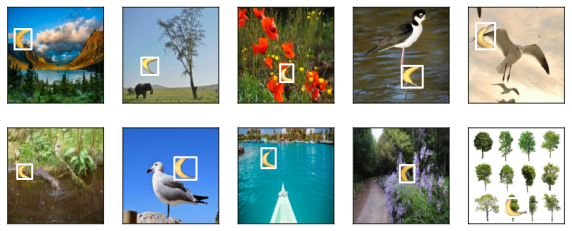

In [110]:
d2l.DATA_HUB['banana-detection'] = d2l.DATA_URL + 'banana-detection.zip', '5de26c8fce5ccdea9f91267273464dc968d20d72'
def read_data_bananas(is_train=True):
    data_dir = d2l.download_extract('banana-detection')
    csv_name = os.path.join(data_dir, 'bananas_train' if is_train else 'bananas_val', 'label.csv')
    csv_data = pd.read_csv(csv_name)
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        images.append(torchvision.io.read_image(os.path.join(data_dir, 'bananas_train' if is_train else 'bananas_val', 
                                                             'images', f'{img_name}')))
        targets.append(list(target))
    return images, torch.tensor(targets).unsqueeze(1) / 256
class BananasDataset(torch.utils.data.Dataset):
    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print(f'read {len(self.features)} {"training examples" if is_train else "validation examples"}')
    def __getitem__(self, idx):
        return self.features[idx].float(), self.labels[idx]
    def __len__(self):
        return len(self.features)
def load_data_bananas(batch_size):
    train_iter = torch.utils.data.DataLoader(BananasDataset(is_train=True), batch_size, shuffle=True)
    val_iter = torch.utils.data.DataLoader(BananasDataset(is_train=False), batch_size)
    return train_iter, val_iter
batch_size, edge_size = 32, 256
train_iter, _ = load_data_bananas(batch_size)
batch = next(iter(train_iter))
print(batch[0].shape, batch[1].shape)

imgs = batch[0][:10].permute(0, 2, 3, 1) / 255
axes = d2l.show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch[1][:10]):
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])

In [133]:
class TinySSD(nn.Module):
    # 5 layer scales: 32x32, 16x16, 8x8, 4x4, 1x1
    def __init__(self, num_classes, sizes, ratios, **kwargs):
        super().__init__(**kwargs)
        self.num_classes = num_classes
        self.sizes = sizes
        self.ratios = ratios
        self.num_anchors = len(sizes[0]) + len(ratios[0]) - 1
        blks, prds = [None] * 5, [None] * 5
        # blk 0: base net (64, 32, 32)
        blks[0] = nn.Sequential(self.down_sample_blk(3, 16), 
                                self.down_sample_blk(16, 32), 
                                self.down_sample_blk(32, 64))
        prds[0] = self.predictors(64)
        # blk 1~3: down_sample_blk (128, 16, 16) ~ (128, 4, 4)
        blks[1], prds[1] = self.down_sample_blk(64, 128), self.predictors(128)
        blks[2], prds[2] = self.down_sample_blk(128, 128), self.predictors(128)
        blks[3], prds[3] = self.down_sample_blk(128, 128), self.predictors(128)
        # blk 4: maxpool (128, 1, 1)
        blks[4], prds[4] = nn.AdaptiveMaxPool2d((1, 1)), self.predictors(128)
        # register modules
        self.blks, self.prds = nn.ModuleList(blks), nn.ModuleList(prds)
    def forward(self, X):
        anchors, cls_preds, pos_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            Y = self.blks[i](X)
            anchors[i] = multibox_prior(Y, self.sizes[i], self.ratios[i])
            cls_preds[i] = self.prds[i][0](Y)
            pos_preds[i] = self.prds[i][1](Y)
            X = Y
        anchors = torch.cat(anchors, dim=1)
        cls_preds = self.concat_preds(cls_preds)
        cls_preds = cls_preds.reshape(cls_preds.shape[0], -1, self.num_classes + 1)
        pos_preds = self.concat_preds(pos_preds)
        return anchors, cls_preds, pos_preds
    @classmethod
    def down_sample_blk(cls, in_channels, out_channels):
        return nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), nn.BatchNorm2d(out_channels), nn.ReLU(),
                             nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1), nn.BatchNorm2d(out_channels), nn.ReLU(),
                             nn.MaxPool2d(2))
    def predictors(self, num_inputs):
        return nn.ModuleList([self.cls_predictor(num_inputs, self.num_anchors, self.num_classes),
                              self.pos_predictor(num_inputs, self.num_anchors)])
    @classmethod
    def cls_predictor(cls, num_inputs, num_anchors, num_classes):
        return nn.Conv2d(num_inputs, num_anchors * (num_classes + 1), kernel_size=3, padding=1)
    @classmethod
    def pos_predictor(cls, num_inputs, num_anchors):
        return nn.Conv2d(num_inputs, num_anchors * 4, kernel_size=3, padding=1)
    @classmethod
    def flatten_pred(cls, pred):
        # return shape (batch, h * w * pred_channels)
        return torch.flatten(pred.permute(0, 2, 3, 1), start_dim=1)
    @classmethod
    def concat_preds(cls, preds):
        return torch.cat([cls.flatten_pred(p) for p in preds], dim=1)

sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
         [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
net = TinySSD(num_classes=1, sizes=sizes, ratios=ratios)
X = torch.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)

print('output anchors:', anchors.shape)
print('output class preds:', cls_preds.shape)
print('output bbox preds:', bbox_preds.shape)

output anchors: torch.Size([1, 5444, 4])
output class preds: torch.Size([32, 5444, 2])
output bbox preds: torch.Size([32, 21776])


class err 3.19e-03, bbox mae 3.15e-03
3833.5 examples/sec on cuda:0


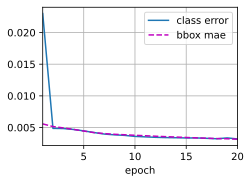

In [134]:
device = d2l.try_gpu()
net = net.to(device)
trainer = torch.optim.SGD(net.parameters(), lr=0.2, weight_decay=5e-4)

cls_loss = nn.CrossEntropyLoss(reduction='none')
bbox_loss = nn.L1Loss(reduction='none')
def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    cls = cls_loss(cls_preds.reshape(-1, num_classes),
                   cls_labels.reshape(-1)).reshape(batch_size, -1).mean(dim=1)
    bbox = bbox_loss(bbox_preds * bbox_masks,
                     bbox_labels * bbox_masks).mean(dim=1)
    return cls + bbox
def cls_eval(cls_preds, cls_labels):
    # Because the class prediction results are on the final dimension,
    # `argmax` needs to specify this dimension
    return float((cls_preds.argmax(dim=-1).type(
        cls_labels.dtype) == cls_labels).sum())
def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float((torch.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())

num_epochs, timer = 20, d2l.Timer()
animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                        legend=['class error', 'bbox mae'])
for epoch in range(num_epochs):
    # Sum of training accuracy, no. of examples in sum of training accuracy,
    # Sum of absolute error, no. of examples in sum of absolute error
    metric = d2l.Accumulator(4)
    net.train()
    for features, target in train_iter:
        timer.start()
        trainer.zero_grad()
        X, Y = features.to(device), target.to(device)
        # Generate multiscale anchor boxes and predict their classes and
        # offsets
        anchors, cls_preds, bbox_preds = net(X)
        # Label the classes and offsets of these anchor boxes
        bbox_labels, bbox_masks, cls_labels = d2l.multibox_target(anchors, Y)
        # Calculate the loss function using the predicted and labeled values
        # of the classes and offsets
        l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels,
                      bbox_masks)
        l.mean().backward()
        trainer.step()
        metric.add(cls_eval(cls_preds, cls_labels), cls_labels.numel(),
                   bbox_eval(bbox_preds, bbox_labels, bbox_masks),
                   bbox_labels.numel())
    cls_err, bbox_mae = 1 - metric[0] / metric[1], metric[2] / metric[3]
    animator.add(epoch + 1, (cls_err, bbox_mae))
print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')
print(f'{len(train_iter.dataset) / timer.stop():.1f} examples/sec on '
      f'{str(device)}')